# Time Series Forecasting of Amazon Stock Prices using RNNs and LSTMs

In this tutorial, we'll build deep learning models to predict Amazon (AMZN) stock prices using time series analysis. We'll implement both Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTMs) networks, which are particularly well-suited for sequential data like stock prices.

Stock price prediction is a challenging problem due to the market's inherent volatility and the influence of numerous external factors. However, neural networks can capture complex temporal patterns in historical data that may help identify trends and make reasonable forecasts.

Let's start by importing the necessary libraries and collecting our historical stock data:

In [1]:
#importing yfinance
import yfinance as yf
#Collecting data
data_raw = yf.download('AMZN',period='5y',interval='1d')
data_raw.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-03-06,95.054497,95.543503,93.474998,93.750000,105472000
2020-03-09,90.030502,93.138496,88.064499,88.693001,156264000
2020-03-10,94.591003,94.713501,90.908501,93.543999,142666000
2020-03-11,91.042999,93.566002,90.074997,92.892502,112496000
2020-03-12,83.830498,88.250000,83.750000,86.098999,226924000


This code retrieves 5 years of Amazon's daily stock data using the Yahoo Finance API. The `yfinance` library provides an easy way to download historical market data from Yahoo Finance.

We specify:
- The ticker symbol 'AMZN' for Amazon
- A 5-year period to ensure we have sufficient historical data
- Daily intervals ('1d') to capture day-to-day price movements

The `.head()` function displays the first few rows of our dataset, giving us a glimpse of the data structure, which typically includes Open, High, Low, Close, and Volume information for each trading day.

In [2]:
data_raw.tail()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2025-02-27,208.740005,219.970001,208.369995,218.350006,40548600
2025-02-28,212.279999,212.619995,206.990005,208.649994,51771700
2025-03-03,205.020004,214.009995,202.550003,213.350006,42948400
2025-03-04,203.800003,206.800003,197.429993,200.110001,60853100
2025-03-05,208.360001,209.979996,203.259995,204.800003,38575100


## Setting Up Our Environment

Next, we import the necessary Python libraries for our time series analysis:

- **pandas** and **numpy**: Essential data manipulation and numerical computation libraries
- **matplotlib**: For data visualization and plotting our results
- **torch**: PyTorch, a deep learning framework that provides tensor computation with GPU acceleration
- **torch.nn**: Neural network module from PyTorch that we'll use to build our RNN and LSTM models

These libraries form the foundation of our data science toolkit for this project, enabling us to process, analyze, visualize, and model our stock price data effectively.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

## Data Preparation

Now we need to prepare our data for analysis. For our time series prediction task, we'll focus on the closing prices of Amazon stock, as they represent the final evaluation of the stock for each trading day.

In this step, we:
1. Extract only the 'Close' price column from our raw dataset into a new DataFrame
2. Reset the index to convert the date from an index to a regular column
3. Rename the former index column to 'Date' for clarity

### Why Focus on Closing Price?

We choose to use only the closing price for several reasons:
- Closing prices represent the final agreed-upon value of the stock after all trading activity for the day
- They are commonly used as the reference point for daily price movements
- Using a single feature simplifies our model while still capturing the essential time series pattern
- For many trading strategies and analyses, the closing price is considered the most important daily indicator
- It reduces dimensionality while maintaining the core temporal information needed for prediction

While a more complex model might incorporate additional features (open, high, low, volume), focusing on close prices provides a good balance between model simplicity and predictive power for this tutorial.

In [4]:
# Extract Date (index) and Close values into a new DataFrame
data = data_raw[['Close']].copy()
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

# Display the new DataFrame
print(data)

Price        Date       Close
Ticker                   AMZN
0      2020-03-06   95.054497
1      2020-03-09   90.030502
2      2020-03-10   94.591003
3      2020-03-11   91.042999
4      2020-03-12   83.830498
...           ...         ...
1251   2025-02-27  208.740005
1252   2025-02-28  212.279999
1253   2025-03-03  205.020004
1254   2025-03-04  203.800003
1255   2025-03-05  208.360001

[1256 rows x 2 columns]


## Setting Up Computation Device

Deep learning models, especially when dealing with sequential data like time series, can benefit significantly from GPU acceleration. In this cell, we're determining whether we can utilize a GPU (CUDA) for training our models:

```python
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Initial Data Visualization

Before diving into model development, it's important to visualize our time series data to understand its patterns and characteristics. In this step, we:

1. Convert the 'Date' column to the proper datetime format using pandas' `to_datetime()` function
2. Create a simple time series plot showing Amazon's closing stock price over our 5-year period

This visualization helps us identify trends, seasonality, potential outliers, and overall behavior of the stock. We can observe whether the stock shows a general upward or downward trend, identify major market events that caused significant price changes, and get an intuition for the volatility of the series.

These observations will inform our approach to feature engineering and model selection in subsequent steps. Time series characteristics like trend and volatility will also help us evaluate whether our predictions are reasonable.

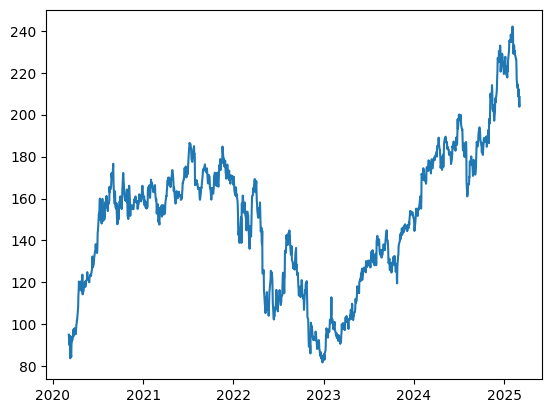

In [43]:
# Make the data column pandas date type
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

## Importance of Time Series Visualization for Model Development

The visualization of Amazon's stock price over time reveals several key characteristics that directly influence our modeling approach:

### Trend Analysis
- **Long-term Trends**: If the data shows a strong upward or downward trend, we might need to consider detrending or differencing the series before modeling
- **Trend Changes**: Points where the trend direction changes may indicate important market events or structural changes that our model should account for

### Volatility Assessment  
- **Variable Volatility**: Periods of high volatility (large price swings) versus stable periods inform us about the expected error margins in different market conditions
- **Volatility Clustering**: Stock prices often show volatility clustering (periods where high volatility days tend to group together), which LSTM models can potentially capture

### Model Selection Implications
Based on these observations:
- Strong trends might suggest using return rates rather than absolute prices
- High volatility periods might require more sophisticated architectures like LSTM over simple RNNs, as LSTMs are better at capturing long-range dependencies and handling irregular patterns
- The complexity of patterns might suggest deeper networks or additional features
- Seasonality patterns (if visible) could inform our feature engineering strategy

Understanding these characteristics helps us make informed decisions about network architecture, loss functions, evaluation metrics, and even the appropriate lookback window size for our time series forecasting task.

## Creating Time-Lagged Features

For time series forecasting with neural networks, we need to restructure our data to create supervised learning examples. Each prediction will be based on a "lookback window" of previous observations.

The function `prepare_dataframe_for_lstm()` transforms our sequential data into a format suitable for training by:

1. Creating a deep copy of the original dataframe to avoid modifying it
2. Setting the 'Date' column as the index for easier temporal operations
3. Generating time-lagged features by shifting the 'Close' price values
4. Removing rows with NaN values that result from the shifting operation

In our implementation, we set `lookback = 7`, which means each prediction will be based on the previous 7 days of stock prices. This creates a sliding window where:
- Our input features are Close(t-1), Close(t-2), ..., Close(t-7)
- Our target variable is the original Close price at time t

This transformation is crucial for recurrent neural networks like LSTMs, as it explicitly encodes the temporal dependencies we want our model to learn. The number of lookback steps is a hyperparameter that balances between:
- Too few steps: Not enough historical context for accurate predictions
- Too many steps: Potentially introducing noise and increasing model complexity

A 7-day lookback window is a reasonable starting point for daily stock data, capturing a week's worth of market activity.

In [44]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Ticker,AMZN,,,,,,,
Date,,,,,,,,
2020-03-17,90.391998,84.457497,89.250000,83.830498,91.042999,94.591003,90.030502,95.054497
2020-03-18,91.500000,90.391998,84.457497,89.250000,83.830498,91.042999,94.591003,90.030502
2020-03-19,94.046501,91.500000,90.391998,84.457497,89.250000,83.830498,91.042999,94.591003
2020-03-20,92.304497,94.046501,91.500000,90.391998,84.457497,89.250000,83.830498,91.042999
2020-03-23,95.141502,92.304497,94.046501,91.500000,90.391998,84.457497,89.250000,83.830498
...,...,...,...,...,...,...,...,...
2025-02-27,208.740005,214.350006,212.800003,212.710007,216.580002,222.880005,226.630005,226.649994
2025-02-28,212.279999,208.740005,214.350006,212.800003,212.710007,216.580002,222.880005,226.630005


## Converting to NumPy Arrays

Before feeding our data into PyTorch models, we need to convert our pandas DataFrame to NumPy arrays, which can then be easily transformed into PyTorch tensors.

In [8]:
# Make this numpy
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 90.39199829,  84.45749664,  89.25      , ...,  94.59100342,
         90.03050232,  95.05449677],
       [ 91.5       ,  90.39199829,  84.45749664, ...,  91.04299927,
         94.59100342,  90.03050232],
       [ 94.04650116,  91.5       ,  90.39199829, ...,  83.83049774,
         91.04299927,  94.59100342],
       ...,
       [205.02000427, 212.27999878, 208.74000549, ..., 212.71000671,
        216.58000183, 222.88000488],
       [203.80000305, 205.02000427, 212.27999878, ..., 212.80000305,
        212.71000671, 216.58000183],
       [208.36000061, 203.80000305, 205.02000427, ..., 214.3500061 ,
        212.80000305, 212.71000671]])

In [9]:
shifted_df_as_np.shape

(1249, 8)

## Data Normalization

Before training our neural networks, we need to normalize the data to improve model convergence and performance. Neural networks generally train better when input features are on a similar scale.

In this step, we:

1. Import `MinMaxScaler` from scikit-learn's preprocessing module
2. Create a scaler that will transform our data to a range between -1 and 1
3. Apply the transformation to our entire NumPy array using `fit_transform()`

### Why Normalize to (-1, 1)?

- **Improved Training Stability**: Neural networks, especially RNNs and LSTMs, train more efficiently with normalized data
- **Prevent Vanishing/Exploding Gradients**: Keeping values in a small range helps prevent numerical instability during backpropagation
- **Symmetrical Activation**: The range (-1, 1) works well with activation functions like tanh, which also has a range of (-1, 1)
- **Better Generalization**: Normalized features often lead to better model generalization

It's crucial to remember that we've stored the scaler object (`scaler`), as we'll need it later to inverse-transform our predictions back to the original scale when evaluating our model.

$$z = (x - x_{min})/(x_{max}- x_{min})$$

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.8930105 , -0.96708067, -0.9072641 , ..., -0.84060155,
        -0.89752243, -0.83481656],
       [-0.87918122, -0.8930105 , -0.96708067, ..., -0.88488518,
        -0.84060155, -0.89752243],
       [-0.84739763, -0.87918122, -0.8930105 , ..., -0.97490641,
        -0.88488518, -0.84060155],
       ...,
       [ 0.53769354,  0.62830755,  0.58412391, ...,  0.6336746 ,
         0.68197708,  0.76060917],
       [ 0.52246636,  0.53769354,  0.62830755, ...,  0.63479787,
         0.6336746 ,  0.68197708],
       [ 0.57938096,  0.52246636,  0.53769354, ...,  0.65414389,
         0.63479787,  0.6336746 ]])

## Preparing Input Features and Target Variables

Now we need to separate our normalized data into input features (X) and target variables (y) for training our models.

In this step:

1. We extract all columns except the first one as our input features (X)
  - `X = shifted_df_as_np[:, 1:]` selects all rows and all columns starting from index 1
  - These columns represent the lagged price values (t-1, t-2, ..., t-7)

2. We extract only the first column as our target variable (y)
  - `y = shifted_df_as_np[:, 0]` selects all rows but only the first column (index 0)
  - This column contains the price we want to predict at time t

In [51]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1249, 7), (1249,))

## Reordering Time Steps

For sequential data processing in RNNs and LSTMs, the order of time steps matters. In this step, we're reordering our input features to ensure they're in chronological order.

When we created our time-lagged features, we generated them in reverse chronological order (from t-1 to t-7). However, for neural networks, it's often more intuitive to feed data in chronological order, starting from the oldest data point and moving toward the most recent.

We use NumPy's `flip()` function to reverse the order of columns in our feature matrix X, making t-7 the first column and t-1 the last column. This means:
- The first column now contains the price from 7 days ago
- The last column now contains the price from yesterday

This chronological ordering aligns better with how RNNs and LSTMs process sequential information, allowing the model to build its understanding from oldest to newest data points. The deep copy (`dc`) ensures we don't accidentally modify our original data.

After this operation, our input features represent a proper time sequence that flows forward in time, which is the natural way for recurrent networks to process temporal data.

In [52]:
# Flipping to make t-7 first
X = dc(np.flip(X, axis=1))
X

array([[-0.83481656, -0.89752243, -0.84060155, ..., -0.97490641,
        -0.9072641 , -0.96708067],
       [-0.89752243, -0.84060155, -0.88488518, ..., -0.9072641 ,
        -0.96708067, -0.8930105 ],
       [-0.84060155, -0.88488518, -0.97490641, ..., -0.96708067,
        -0.8930105 , -0.87918122],
       ...,
       [ 0.76060917,  0.68197708,  0.6336746 , ...,  0.65414389,
         0.58412391,  0.62830755],
       [ 0.68197708,  0.6336746 ,  0.63479787, ...,  0.58412391,
         0.62830755,  0.53769354],
       [ 0.6336746 ,  0.63479787,  0.65414389, ...,  0.62830755,
         0.53769354,  0.52246636]])

## Train-Test Split

Before training our models, we need to divide our data into training and testing sets. This separation is crucial for evaluating how well our model generalizes to unseen data.

In this step, we:

1. Define a split point at 95% of our data
  - We're using 95% of the data for training and 5% for testing
  - This is a common split ratio for time series forecasting, as we want to maximize the amount of sequential data available for training

2. Split our features X and target y into training and testing sets:
  - X_train: Features for training the model
  - X_test: Features for evaluating the model
  - y_train: Target values for training
  - y_test: Target values for evaluating predictions

3. Verify the shapes of our resulting arrays to ensure the split was performed correctly

Note that we're performing a chronological split rather than a random split, which is essential for time series data. This approach preserves the temporal structure of our data and simulates a real-world forecasting scenario where we use historical data to predict future values.

The test set represents the most recent 5% of our trading days, which allows us to evaluate how well our model can predict the most current market conditions.

In [53]:
split_index = int(len(X) * 0.95)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 7), (63, 7), (1186,), (63,))

## Reshaping Data for RNN/LSTM Input

RNN and LSTM models in PyTorch expect input data in a specific format. We need to reshape our arrays to match the expected dimensions.

For feature inputs (X), PyTorch's recurrent models expect 3D tensors with shape:
- (batch_size, sequence_length, input_features)

For target outputs (y), we need 2D tensors with shape:
- (batch_size, output_features)

In this reshaping operation:

1. We reshape X_train and X_test to have dimensions (samples, lookback, features):
  - samples: number of training/testing examples
  - lookback: number of time steps (7 days in our case)
  - features: number of features per time step (1, since we're only using closing price)

2. We reshape y_train and y_test to have dimensions (samples, 1):
  - This format is required for our loss functions and makes it easier to process predictions

This reshaping transforms our data from a 2D matrix to a 3D tensor for X, making it compatible with the input requirements of recurrent neural networks. Each sample now represents a sequence of lookback days, with each day containing a single feature (the normalized closing price).

In [54]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 7, 1), (63, 7, 1), (1186, 1), (63, 1))

In [55]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1186, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1186, 1]),
 torch.Size([63, 1]))

## Creating PyTorch Datasets

Now that our data is properly formatted, we need to create PyTorch Dataset objects to efficiently load and batch our data during training. PyTorch's data loading utilities provide optimized methods for feeding data to our models.

The `TimeSeriesDataset` class we've defined is a custom implementation of PyTorch's abstract `Dataset` class. This implementation requires us to define three methods:

1. `__init__`: Initializes the dataset with our feature matrix X and target vector y
2. `__len__`: Returns the total number of samples in the dataset
3. `__getitem__`: Returns a specific (feature, target) pair at the requested index

By implementing these methods, our custom dataset enables:
- Efficient batching during training
- Compatibility with PyTorch's DataLoader
- Random sampling or sequential access to our time series data
- Potential for on-the-fly data transformations (if needed later)

We then create two dataset instances:
- `train_dataset`: Contains our training data for model learning
- `test_dataset`: Contains our test data for model evaluation

These dataset objects will be used with PyTorch's DataLoader to create batches of data during model training and evaluation, which helps manage memory efficiently and can speed up the training process.

In [56]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [57]:
train_dataset

## Creating Data Loaders

Now that we have our Dataset objects, we need to create DataLoader instances to efficiently batch our data during training and evaluation. PyTorch's DataLoader class provides several important features for training deep learning models effectively.

In this step, we:

1. Set our `batch_size` to 16
  - This means our model will process 16 sequences at a time
  - Batch processing improves training efficiency and helps with generalization
  - The batch size is a hyperparameter that balances between computational efficiency and gradient accuracy

2. Create two DataLoader instances:
  - `train_loader`: For our training data, with shuffling enabled
  - `test_loader`: For our test data, with shuffling disabled

### Important DataLoader Parameters:

- **batch_size=16**: Processes 16 samples at once, which helps optimize GPU utilization while keeping memory requirements reasonable
- **shuffle=True** (for training): Randomizes the order of samples in each epoch, which helps prevent the model from learning the order of training examples and improves generalization
- **shuffle=False** (for testing): Maintains the chronological order of our test data, which is important for time series evaluation

The DataLoader objects will handle the complexity of batching and shuffling, allowing us to focus on model architecture and training procedures. During training, we'll iterate through the `train_loader` to get batches of data, and during evaluation, we'll use the `test_loader` to assess our model's performance.

In [58]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [59]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


## Building the RNN Model

Now we'll build our first neural network model: a simple Recurrent Neural Network (RNN). This model will serve as our baseline before we implement the more advanced LSTM architecture.

This class defines a standard RNN with a fully connected layer at the output. Let's break down its components:

### RNN Class Structure:

1. **Initialization (`__init__`)**:
  - `input_size`: Dimension of input features (1 in our case, as we're only using closing price)
  - `hidden_size`: Number of features in the hidden state (4 in our example)
  - `num_stacked_layers`: Number of stacked RNN layers (1 in our example)
  - Creates an RNN layer with the specified parameters
  - Adds a fully connected layer to map the hidden state to our prediction

2. **Forward Pass (`forward`)**:
  - Creates an initial hidden state (h0) filled with zeros
  - Processes the input sequence through the RNN
  - Takes the output from the last time step and passes it through the fully connected layer
  - Returns the final prediction

### Key RNN Parameters:

- **batch_first=True**: Indicates that our input tensor has shape (batch_size, seq_length, features)
- **h0 initialization**: Creates the initial hidden state with dimensions (num_layers, batch_size, hidden_size)
- **out[:, -1, :]**: Selects only the output from the last time step, as we're interested in predicting one step ahead

### Mathematical Foundation:

The standard RNN updates its hidden state at each time step t as:
$$h_t = tanh(W_{ih} * x_t + b_{ih} + W_{hh} * h_{(t-1)} + b_{hh})$$

Where:
- $h_t$ is the hidden state at time t
- $x_t$ is the input at time t
- $W_{ih}, W_{hh}$ are weight matrices
- $b_{ih}, b_{hh}$ are bias terms

This simple RNN will serve as our baseline, but it may struggle with longer sequences due to the vanishing gradient problem, which we'll address when implementing the LSTM model.

In [60]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Replace LSTM with RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)  # Note the change here: RNN only needs h0
        out = self.fc(out[:, -1, :])
        return out

# Example usage
model_rnn = RNN(1, 4, 1)
model_rnn.to(device)


RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [61]:
def train_one_epoch():
    model_rnn.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model_rnn(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [62]:
def validate_one_epoch():
    model_rnn.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model_rnn(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

## Training the RNN Model

Now we implement the training procedure for our RNN model. The code defines two key functions for the training process and sets up the necessary hyperparameters.

### Training and Validation Functions

1. **train_one_epoch()**:
  - Sets the model to training mode with `model_rnn.train(True)`
  - Iterates through batches from our training DataLoader
  - Computes model predictions and calculates loss
  - Performs backpropagation and parameter updates
  - Tracks and reports running loss every 100 batches for monitoring progress

2. **validate_one_epoch()**:
  - Sets the model to evaluation mode with `model_rnn.train(False)`
  - Processes batches from the test DataLoader
  - Uses `torch.no_grad()` to disable gradient calculations during evaluation
  - Calculates and reports average validation loss

### Hyperparameters and Training Setup

- **Learning Rate (0.001)**: Controls the step size during optimization
- **Number of Epochs (50)**: Defines how many times the model will process the entire dataset
- **Loss Function (MSELoss)**: Mean Squared Error loss, appropriate for regression problems
- **Optimizer (Adam)**: An adaptive optimization algorithm that adjusts learning rates based on gradient history

### The Training Loop

The main training loop runs for the specified number of epochs, calling both training and validation functions in each iteration. This approach allows us to:
- Train the model on the training data
- Evaluate its performance on unseen test data
- Monitor for potential overfitting or convergence issues

This iterative process of training and validation is fundamental in deep learning, as it helps us understand how well our model generalizes to new data and whether adjustments are needed to improve performance.

In [63]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.795
***************************************************

Epoch: 2

Val Loss: 0.693
***************************************************

Epoch: 3

Val Loss: 0.309
***************************************************

Epoch: 4

Val Loss: 0.200
***************************************************

Epoch: 5

Val Loss: 0.191
***************************************************

Epoch: 6

Val Loss: 0.186
***************************************************

Epoch: 7

Val Loss: 0.177
***************************************************

Epoch: 8

Val Loss: 0.168
***************************************************

Epoch: 9

Val Loss: 0.158
***************************************************

Epoch: 10

Val Loss: 0.148
***************************************************

Epoch: 11

Val Loss: 0.135
***************************************************

Epoch: 12

Val Loss: 0.129
***************************************************

Epoch: 13

Val Loss: 0.121
**********************

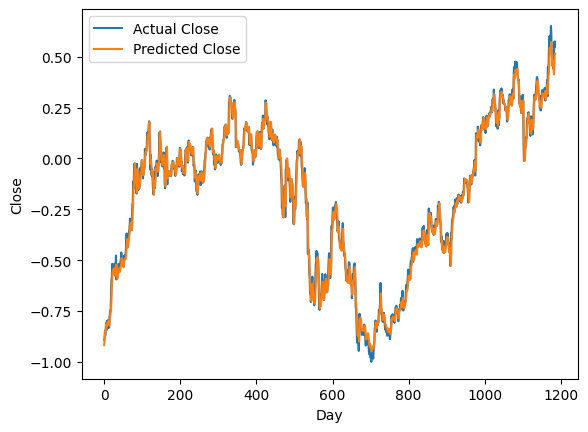

In [64]:
with torch.no_grad():
    predicted_rnn = model_rnn(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


## Visualizing Training Set Predictions

After training our RNN model, it's crucial to visualize how well it's performing. This visualization helps us understand the model's strengths and limitations by comparing predictions against actual values.

In this code:

1. We use `torch.no_grad()` to disable gradient calculation during inference, which:
  - Reduces memory usage
  - Speeds up computation
  - Is standard practice when not training

2. We generate predictions on the training data by:
  - Passing our training features to the model
  - Moving results back to CPU and converting to NumPy for plotting

3. We create a comparative plot showing:
  - The actual close prices (ground truth)
  - The predicted close prices from our RNN model
  - Proper labeling and legend for clarity

### Interpreting the Plot

This visualization helps us assess:
- **Overall Trend Capture**: How well does the model follow the general price movement?
- **Prediction Accuracy**: How closely do predictions align with actual values?
- **Potential Overfitting**: Is the model learning the training data too perfectly?
- **Error Patterns**: Are there specific patterns where predictions consistently fail?

Remember that these are predictions on the training data, which the model has already seen. A model that performs well on training data but poorly on test data may be overfitting. In the next step, we should evaluate performance on the test set to better assess generalization.

In [65]:
train_predictions_rnn = predicted_rnn.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions_rnn
dummies = scaler.inverse_transform(dummies)

train_predictions_rnn = dc(dummies[:, 0])
train_predictions_rnn

array([ 88.42886657,  90.61279013,  92.20607688, ..., 197.37759165,
       202.70197148, 203.17484387])

In [66]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train_rnn = dc(dummies[:, 0])
new_y_train_rnn

array([ 90.39199855,  91.50000132,  94.04650178, ..., 207.86000071,
       205.74000708, 207.89000055])

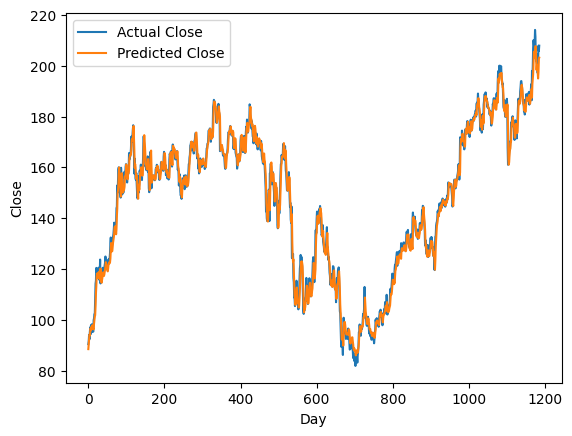

In [67]:
plt.plot(new_y_train_rnn, label='Actual Close')
plt.plot(train_predictions_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Evaluating and Visualizing Test Set Predictions

Now that we've trained our RNN model and examined its performance on the training data, we need to evaluate how well it generalizes to unseen data. This is a crucial step in assessing the model's real-world applicability.

In this code, we:

1. **Generate Test Set Predictions**:
   - Feed the test data into our trained model
   - Detach the results from the computation graph, move them to CPU, and convert to NumPy
   - Flatten the output array for easier processing

2. **Inverse Transform the Predictions**:
   - Create a dummy array with the right dimensions (matching our original data structure)
   - Place our predictions in the first column (index 0)
   - Apply the inverse transform using our saved scaler to convert from normalized (-1,1) range back to original stock prices
   - Extract the first column which contains our denormalized predictions

3. **Process Actual Test Values**:
   - Perform the same inverse transformation on our actual y_test values
   - This ensures both predictions and actual values are on the same scale

4. **Visualize the Results**:
   - Plot both the actual close prices and predicted close prices
   - Add appropriate labels and legend for clarity

In [68]:
test_predictions_rnn = model_rnn(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions_rnn
dummies = scaler.inverse_transform(dummies)

test_predictions_rnn = dc(dummies[:, 0])
test_predictions_rnn

array([203.56566321, 205.45337057, 207.84085563, 211.13820219,
       213.37888286, 217.29151271, 217.89262703, 216.7892804 ,
       219.22747675, 219.72297557, 218.52525026, 220.99718568,
       221.26595218, 214.93281452, 214.03712677, 216.02539234,
       216.87475273, 218.87318539, 218.45242352, 216.08452766,
       213.91253335, 212.50859613, 212.81193742, 215.38571567,
       218.18875728, 215.66578105, 214.16602772, 212.41980003,
       211.71838538, 211.32472461, 214.45527166, 214.24126132,
       216.42629281, 220.01837517, 223.2417202 , 223.91700796,
       223.29263684, 223.35391637, 224.96288594, 224.93723182,
       223.30300928, 224.38501887, 224.98860691, 227.33150767,
       224.98185432, 225.09268468, 220.54528739, 220.94654603,
       221.83848976, 219.89112655, 219.73880166, 219.21711863,
       217.90683422, 217.45470192, 215.49151263, 211.20893725,
       207.64338293, 207.12191958, 208.44194129, 205.68037989,
       206.30051989, 202.89421498, 200.51842995])

In [69]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test_rnn = dc(dummies[:, 0])
new_y_test_rnn

array([210.71000482, 213.44000479, 218.16000385, 220.55000083,
       227.03000019, 226.08999558, 225.03999155, 230.25999275,
       228.96999954, 227.46000748, 232.92999304, 231.14999285,
       220.52000577, 223.2899912 , 224.91999696, 225.05999622,
       229.05000389, 227.05000486, 223.74999833, 221.30000166,
       219.38999738, 220.22000257, 224.19000079, 227.61000191,
       222.11000218, 222.13000685, 218.94000452, 218.46000705,
       217.7599964 , 223.35000521, 220.66000503, 225.94000114,
       230.71000471, 235.00999643, 235.41999905, 234.85000682,
       235.41999905, 238.14999424, 237.07000947, 234.63999837,
       237.67999194, 237.41999808, 242.05999756, 236.16999988,
       238.83000022, 229.14999381, 233.14000149, 232.75999393,
       228.92999497, 230.36999695, 228.67999151, 226.64999263,
       226.63000707, 222.88000291, 216.58000261, 212.71000863,
       212.80000338, 214.35000478, 208.74000563, 212.27999657,
       205.02000609, 203.80000295, 208.36000285])

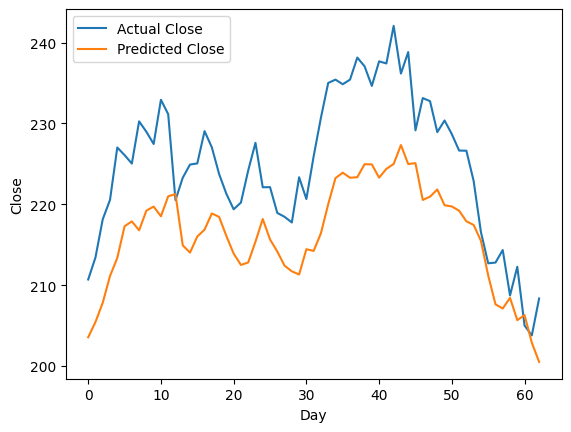

In [70]:
plt.plot(new_y_test_rnn, label='Actual Close')
plt.plot(test_predictions_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


### Interpreting Test Results

The test set visualization is particularly important because it shows how well our model performs on data it hasn't seen during training. When analyzing this plot, look for:

- **Prediction Accuracy**: How closely do the predicted values follow the actual prices?
- **Trend Capture**: Does the model correctly identify upward and downward trends?
- **Lag Effects**: Is there a delay in the model's response to price changes?
- **Error Consistency**: Are errors randomly distributed or systematic?

This evaluation on unseen data provides a more realistic assessment of how the model would perform in a real-world trading scenario, where we're predicting future prices based on historical data.

### LSTM

## Building the LSTM Model

After implementing our baseline RNN model, we now build a more sophisticated Long Short-Term Memory (LSTM) network. LSTMs are specifically designed to overcome the vanishing gradient problem that affects standard RNNs when dealing with longer sequences.

### LSTM Architecture

The LSTM class follows a similar structure to our RNN but with key differences in the recurrent mechanism:

1. **Initialization (`__init__`)**:
  - Same parameters as our RNN: `input_size`, `hidden_size`, and `num_stacked_layers`
  - Uses PyTorch's built-in LSTM layer instead of RNN
  - Maintains the same fully connected output layer for predictions

2. **Forward Pass (`forward`)**:
  - Initializes both hidden state (h0) and cell state (c0) with zeros
  - Processes input through the LSTM layer, providing both initial states
  - Takes the output from the last time step and passes it through the fully connected layer

### Key LSTM Differences from RNN:

- **Cell State**: LSTMs maintain both a hidden state and a cell state, with the latter serving as a "memory cell"
- **Gating Mechanisms**: LSTMs use three gates (input, forget, output) to control information flow
- **Initial States**: Both h0 and c0 must be initialized and passed to the forward function

### Mathematical Foundation:

LSTMs compute the following at each time step t:
- Forget gate: $f_t = \sigma(W_f·[h_{t-1},x_t] + b_f)$
- Input gate: $i_t = \sigma(W_i·[h_{t-1},x_t] + b_i)$
- Cell candidate: $\tilde{C}_t = \tanh(W_C·[h_{t-1},x_t] + b_C)$
- Cell state: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$
- Output gate: $o_t = \sigma(W_o·[h_{t-1},x_t] + b_o)$
- Hidden state: $h_t = o_t * \tanh(C_t)$

Where:
- $\sigma$ is the sigmoid function
- $*$ denotes element-wise multiplication

These gating mechanisms allow LSTMs to better model long-term dependencies in sequential data, making them particularly suitable for time series prediction tasks like stock price forecasting.

In [71]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [72]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [73]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [74]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.852
***************************************************

Epoch: 2

Val Loss: 0.750
***************************************************

Epoch: 3

Val Loss: 0.491
***************************************************

Epoch: 4

Val Loss: 0.211
***************************************************

Epoch: 5

Val Loss: 0.073
***************************************************

Epoch: 6

Val Loss: 0.073
***************************************************

Epoch: 7

Val Loss: 0.073
***************************************************

Epoch: 8

Val Loss: 0.078
***************************************************

Epoch: 9

Val Loss: 0.074
***************************************************

Epoch: 10

Val Loss: 0.071
***************************************************

Epoch: 11

Val Loss: 0.063
***************************************************

Epoch: 12

Val Loss: 0.060
***************************************************

Epoch: 13

Val Loss: 0.056
**********************

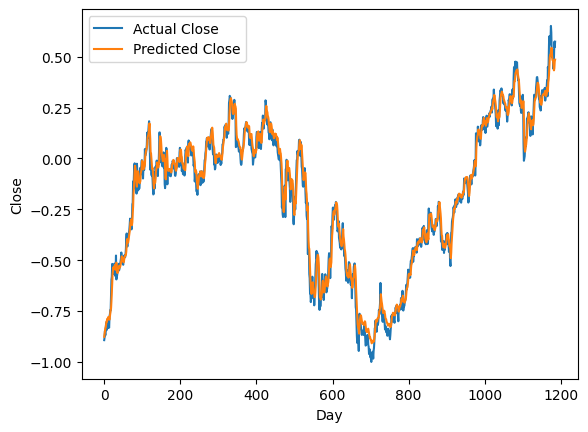

In [75]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [76]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 91.71542999,  92.74749715,  93.71106897, ..., 197.40821231,
       200.10841778, 200.82582089])

In [77]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 90.39199855,  91.50000132,  94.04650178, ..., 207.86000071,
       205.74000708, 207.89000055])

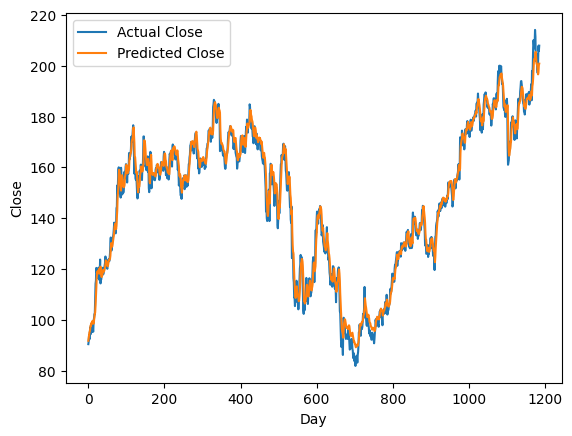

In [78]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [79]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([202.01633038, 203.57179021, 205.25060182, 207.59804888,
       209.50297678, 212.36716898, 213.49796055, 213.81893785,
       215.42195712, 215.79775744, 215.60737639, 216.98277986,
       217.12374378, 214.33732099, 213.7815455 , 213.83617272,
       213.87185066, 215.02118081, 215.0340413 , 214.1865768 ,
       213.08408498, 211.93073861, 211.55460401, 212.49344339,
       213.91181702, 213.09146794, 212.77568641, 211.64432656,
       210.91230557, 210.28689816, 211.62586916, 211.47705427,
       213.01068518, 215.05681577, 217.1902334 , 218.3449599 ,
       218.81441779, 219.20503656, 220.05582005, 220.16690352,
       219.64735515, 220.16070489, 220.29442911, 221.47922708,
       220.61310461, 220.92865691, 218.62169197, 218.58198826,
       218.34120634, 217.22195243, 217.08396366, 216.53554725,
       215.72604339, 215.32776468, 214.05276661, 211.57590762,
       209.09905341, 207.78354934, 207.55092879, 205.61731431,
       205.83950035, 203.50800353, 201.89952107])

In [80]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([210.71000482, 213.44000479, 218.16000385, 220.55000083,
       227.03000019, 226.08999558, 225.03999155, 230.25999275,
       228.96999954, 227.46000748, 232.92999304, 231.14999285,
       220.52000577, 223.2899912 , 224.91999696, 225.05999622,
       229.05000389, 227.05000486, 223.74999833, 221.30000166,
       219.38999738, 220.22000257, 224.19000079, 227.61000191,
       222.11000218, 222.13000685, 218.94000452, 218.46000705,
       217.7599964 , 223.35000521, 220.66000503, 225.94000114,
       230.71000471, 235.00999643, 235.41999905, 234.85000682,
       235.41999905, 238.14999424, 237.07000947, 234.63999837,
       237.67999194, 237.41999808, 242.05999756, 236.16999988,
       238.83000022, 229.14999381, 233.14000149, 232.75999393,
       228.92999497, 230.36999695, 228.67999151, 226.64999263,
       226.63000707, 222.88000291, 216.58000261, 212.71000863,
       212.80000338, 214.35000478, 208.74000563, 212.27999657,
       205.02000609, 203.80000295, 208.36000285])

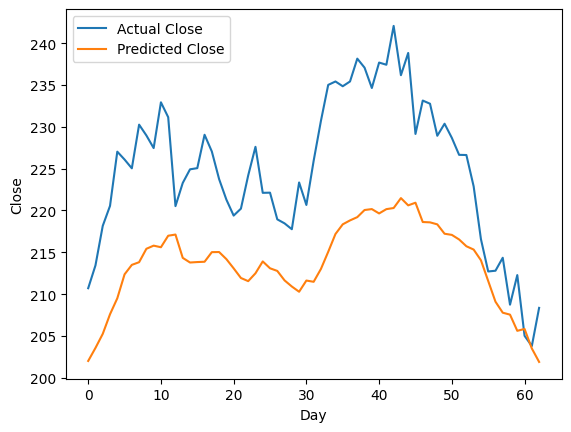

In [81]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


### Potential Enhancements
For a more comprehensive analysis, you might consider:

1. **Feature Engineering**:
  - Technical indicators (RSI, MACD, moving averages)
  - Volatility measures
  - Trading volume as an additional feature
  - External factors (market indices, related stocks)

2. **Data Validation**:
  - Creating a separate validation set for hyperparameter tuning
  - Implementing k-fold or time series cross-validation

3. **Stationarity Analysis**:
  - Testing for stationarity with methods like Augmented Dickey-Fuller test
  - Differencing the series if non-stationary

4. **Outlier Detection**:
  - Identifying and handling market anomalies or extreme events

5. **Extended Preprocessing**:
  - Data augmentation techniques
  - Exploring multiple normalization approaches
  - Implementing rolling window statistics

6. **Visualization**:
  - Correlation heatmaps for lagged features
  - Distribution plots to examine data characteristics

These enhancements could potentially improve model performance, but our current preprocessing pipeline provides a solid foundation for implementing and evaluating our deep learning models.